**Импорт библиотек:**

In [1]:
pip install phik shap -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from IPython.display import display

# модули для работы с моделями:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier, DummyRegressor

# Кодировщики, масштабировние
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Модели
from sklearn.linear_model import LinearRegression

# Метрики
from sklearn.metrics import make_scorer, mean_squared_error


import phik
import shap

**Константы**

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и подготовка данных

Функции, которыми будем пользоваться:

In [4]:
# Функция для отображения части датасета и информации о нем
def show_info(df):
    display(df.head())
    df.info()

### Предобработка данных ###
# 1. Для поиска и просмотра явных дубликатов:
def duplicates_find(df):
    
    # Если дубликаты есть:    
    if df.duplicated().sum()>0:
        # Количество явных дубликатов
        print ('Количество явных дубликатов:', df.duplicated().sum())
        # Выводим на экран дубликаты
        display(df.loc[df.duplicated()])
    # Если дубликатов нет:
    else:
        print ('Явных дубликатов не найдено')
        
# 2. Для просмотра уникальных значений объектов типа Object: 
def uniques(df):
    for column in df.columns:
        if df[column].dtype == 'O':
            print (f'{column}: \n {df[column].unique()} \n ')
            
# 3. Пайплайн для заполнения пропусков модой
imp_pipe = Pipeline(
    [
        ('SimpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))        
    ]
)

### Графики ### 
# 1. Для непрерывных величин - гистограмма и ящик с усами
def make_hist(df, column, bins, p, x_name):
    f, ax = plt.subplots(1, 2)
    f.set_size_inches(20, 5)
    plt.suptitle(f'data_{p}', fontweight='bold')
    # Гистограмма:
    sns.histplot(data=df, x=column, bins=bins, color='coral', edgecolor=None, ax=ax[0])
    ax[0].set_title(f'Распределение признака {column}')
    ax[0].grid()
    ax[0].set_xlabel(x_name)
    ax[0].set_ylabel('частота')
    # Ящик с усами:
    ## vert=False, чтобы значения признака были по горизонтальной оси для обоих графиков
    sns.boxplot(data=df, x=column, orient='h', color='cornflowerblue')
    ax[1].set_title(f'Ящик с усами - {column}')
    ax[1].grid()
    ax[1].set_xlabel(x_name)
    plt.show()

# 2. Для непрерывных величин - сразу для 3 датасетов
def make_hists(column, bins, x_name):
    p=0
    for i in list_data:
        make_hist(i, column, bins, p, x_name)
        display(pd.DataFrame(i[column].describe()).T)
        p+=1

### Загрузка данных:

In [5]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Ознакомимся с датасетами:

In [6]:
show_info(data_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
show_info(data_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
show_info(data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Данные загружены успешно. В них содержится одинаковое количество строк, одинаковые количество и названия столбцов, типы переменных.

#### Вывод:

В каждом из датасетов:  

100000 строк, 5 столбцов 

Типы данных корректны:
* `id` - object
* Оставшиеся столбцы - float

Названия столбцов корректны, изменений не требуется

Нет пропусков в столбцах.

`id` - уникальный идентификатор скважины -  указан не числом, а буквенным обозначением с использованием разных регистров.

Координаты `f0`, `f1`, `f2` имеют как положительные, так и отрицательные значения.

### Предобработка данных

**Пропуски:**

Еще раз убедимся в их отсутствии.

In [9]:
list_data = [data_0, data_1, data_2]
p=0
for i in list_data:
    print ((i.isna().sum()).sum(), f'- сумма пропусков во всех столбцах data_{p}')
    p+=1

0 - сумма пропусков во всех столбцах data_0
0 - сумма пропусков во всех столбцах data_1
0 - сумма пропусков во всех столбцах data_2


* Пропусков нет

**Явные дубликаты:**

In [10]:
for i in list_data:
    duplicates_find(i)

Явных дубликатов не найдено
Явных дубликатов не найдено
Явных дубликатов не найдено


Проверим, не будет ли дубликатов, если объединить все датасеты в одну таблицу:

In [11]:
data_full = pd.concat([data_0, data_1])
data_full = pd.concat([data_full, data_2])
duplicates_find(data_full)

Явных дубликатов не найдено


* Каждая строка уникальна

**Неявные дубликаты:**

In [12]:
p=0
for i in list_data:
    print (f'\n data_{p}:')
    uniques(i)
    print ('Количество уникальных значений:', i['id'].nunique())
    p+=1


 data_0:
id: 
 ['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH'] 
 
Количество уникальных значений: 99990

 data_1:
id: 
 ['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0'] 
 
Количество уникальных значений: 99996

 data_2:
id: 
 ['fwXo0' 'WJtFt' 'ovLUW' ... 'tKPY3' 'nmxp2' 'V9kWn'] 
 
Количество уникальных значений: 99996


* В каждом датасете всего один столбец типа object - `id`.

* Есть повторяющиеся значения, поскольку количество уникальных значений не равно числу строк в датасетах - 100000.

Это не могут быть дублированные строки, поскольку ранее определили, что полных дубликатов в датасетах у нас нет:
* для каждой пары совпадающих `id` различается как минимум один из признаков.

**в связи с этим повторяющиеся `id` и соответствующие строки в датасете оставяляем, без изменений.**

Посмотрим, есть ли скважины с полностью дублированными значениями, если убрать из них `id`:

In [13]:
duplicates_find(data_full.drop('id', axis=1))

Явных дубликатов не найдено


#### Вывод:


Пропусков, дубликатов (явных и неявных) обнаружено не было.

Есть повторяющиеся `id`. Однако, нет таких строк, где кроме `id` совпадали бы другие признаки.

Можем предположить, что имела место ошибка при записи данных. Либо в данном случае `id` это не "идентификационный номер", а наименование места исследования, которое может содержать в себе информацию о характеристиках и свойствах скважины, поэтому может повторяться.

### Исследовательский анализ данных

Посмотрим, как распределәөтся признаки. Сравним распределения в трех датасетов.

**Признак `product`:**

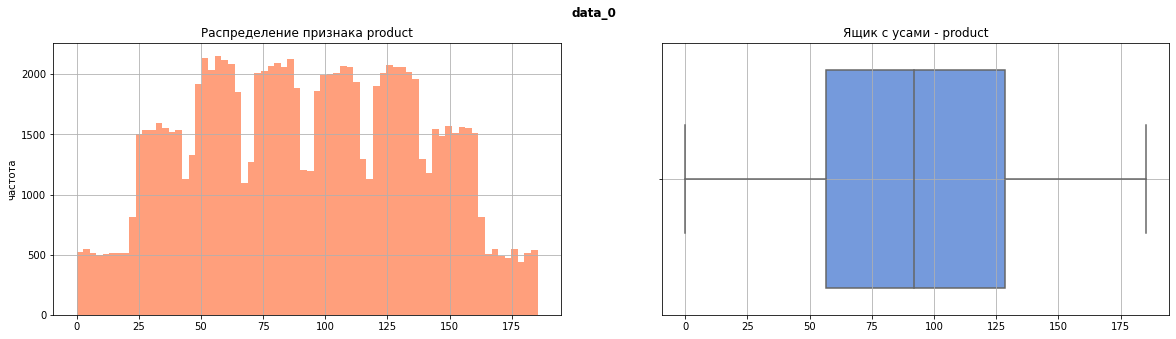

,count,mean,std,min,25%,50%,75%,max
product,100000.0,92.5,44.288691,0.0,56.497507,91.849972,128.564089,185.364347


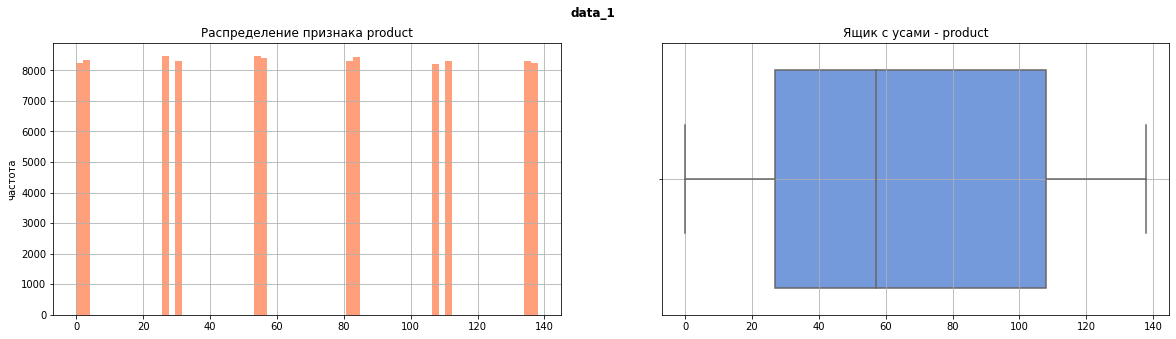

,count,mean,std,min,25%,50%,75%,max
product,100000.0,68.825,45.944423,0.0,26.953261,57.085625,107.813044,137.945408


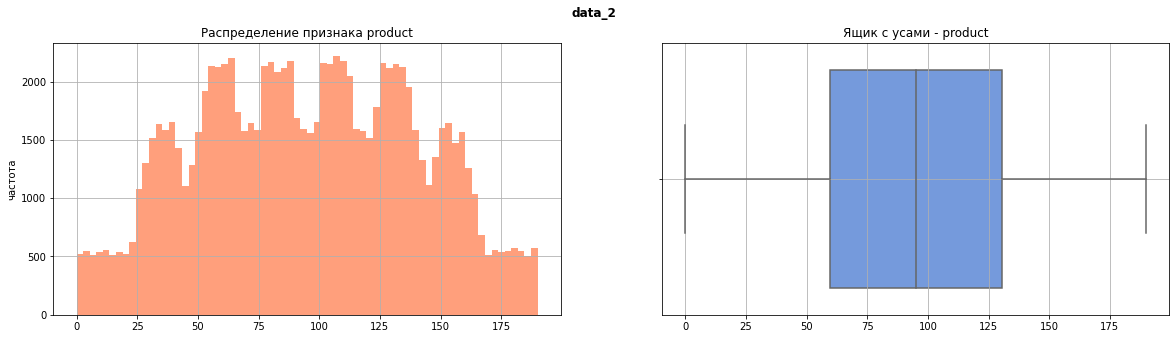

,count,mean,std,min,25%,50%,75%,max
product,100000.0,95.0,44.749921,0.0,59.450441,94.925613,130.595027,190.029838


In [14]:
make_hists('product', 70, '')

Самые высокие объемы запаса в data_0 и data_2:
* Среднее 92.5/95
* Разброс
  * от 56.5 до 185.4
  * от 59.5 до 190
  
В data_1 меньше уникальных значений. Возможно, это связано с тем, что данные синтетические.
* Среднее 68.8
* Разброс от 27 до 138

Видно большое количество объемов запаса, близких к нулю.  
Посмотрим, сколько их в датасетах:

In [15]:
p=0
print ('Количество строк, в которых значение product меньше единицы:')
for i in list_data:
    print (f'\n data_{p} - ', i.query('product<1')['product'].count())
    p+=1
    
p=0
print ('\nДоля таких скважин в датасете:')
for i in list_data:
    print (f'\n data_{p} - ', round(i.query('product<1')['product'].count()/len(i), 3))
    p+=1

Количество строк, в которых значение product меньше единицы:

 data_0 -  194

 data_1 -  8235

 data_2 -  191

Доля таких скважин в датасете:

 data_0 -  0.002

 data_1 -  0.082

 data_2 -  0.002


В основном нулевые значения `product` видим во втором датасете.  

Нулевые значения могут объясняться:
- при геологоразведке действительно не было обнаружено нефти
- взяты пробы в уже исчперпанных скважинах
- ошибками при вводе данных, т.к. они синтетические


Также видим, что в data_1 очень маленький разброс значений. Посмотрим, сколько уникальных значений `product` есть в data_1:

In [16]:
data_1['product'].nunique()

12

* Всего 12 уникальных значений признака "объём запасов".  

В обзем случае для всех датасетов имеем такое распределение признака:

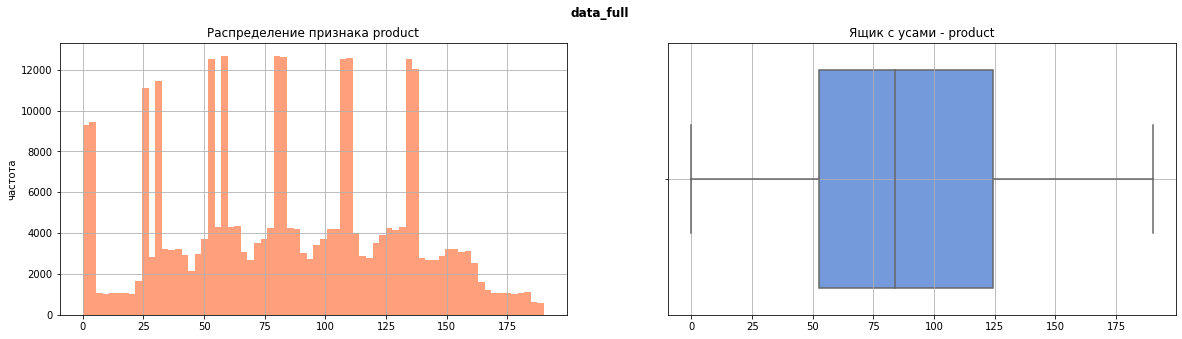

,count,mean,std,min,25%,50%,75%,max
product,300000.0,85.441667,46.519494,0.0,52.666629,84.038886,124.174086,190.029838


In [17]:
make_hist(data_full, 'product', 70, 'full', '')
pd.DataFrame(data_full['product'].describe()).T

**Признак `f0`:**

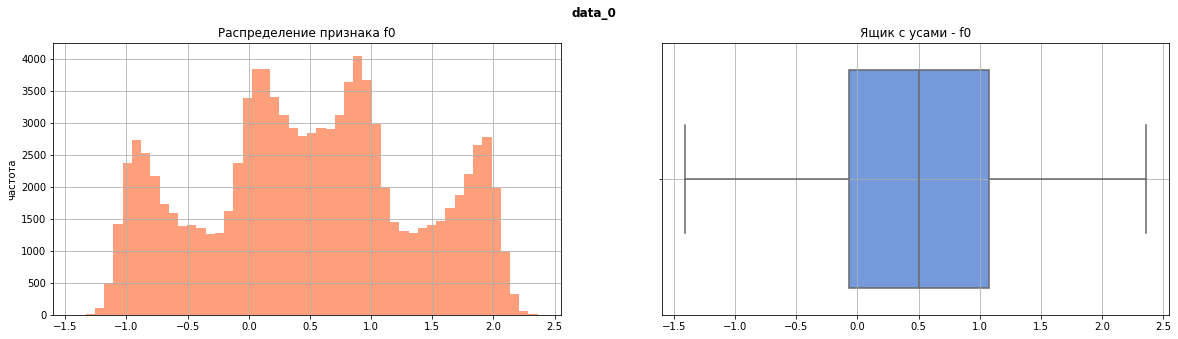

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.07258,0.50236,1.073581,2.362331


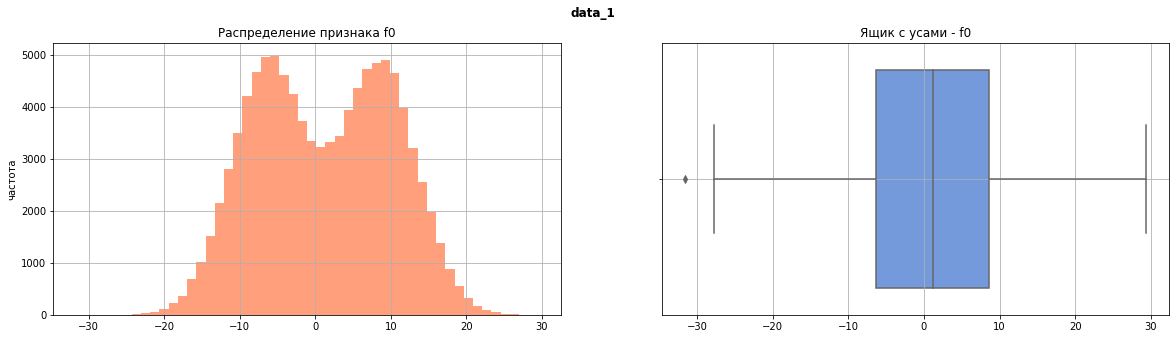

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755


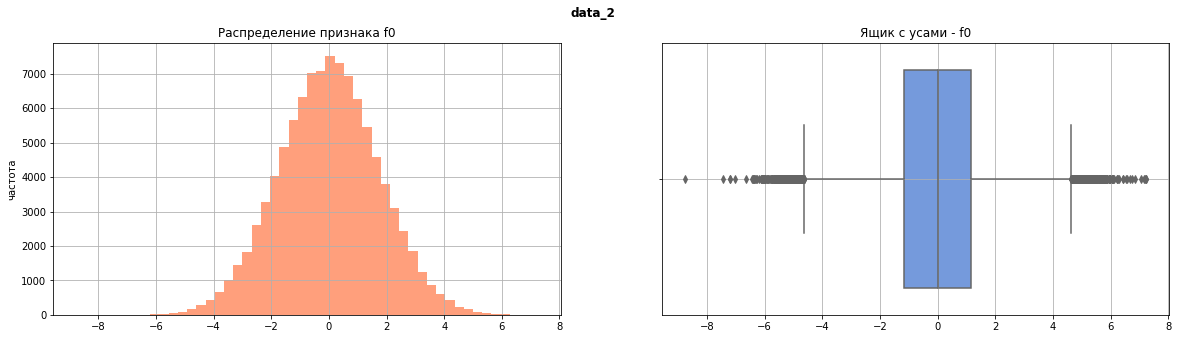

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262


In [18]:
make_hists('f0', 50, '')

Признак сильно различается у датасетов.

Разбросы:
* data_0 - от -1.4 до 2.4
* data_1 - от -31.6 до 29.4
* data_2 - от -8.8 до 7.2  
Если речь идет о координатах, то такие различия понятны и закономерны.

Средние в районе нуля (у data_0 чуть выше - 0.5)

Данные распределены в data_0 и data_1 с несколькими пиками.

В data_2 распределение близко к нормальному.

*Выбросы в data_2:*

Поскольку эти значения не сильно, не критично отличаются от остальных, вряд ли их можно назвать выбросами. 

Тем не менее посмотрим, не меняется ли при этих значениях признак `product`:

In [19]:
# Выбросы с высоким значением
display(pd.DataFrame(data_2.query('f0 < -4.7')['product'].describe()).T)
# Выбросы с низким значением
display(pd.DataFrame(data_2.query('f0 > 4.7')['product'].describe()).T)

# Оставшиеся значения, берем без учета скважин с нулевым объемом запасов
display(pd.DataFrame(data_2.query('f0 < 4.7 and f0 > -4.7 and product>1')['product'].describe()).T)

,count,mean,std,min,25%,50%,75%,max
product,320.0,109.450813,42.616376,29.444386,73.679409,109.713217,140.202814,188.162856


,count,mean,std,min,25%,50%,75%,max
product,347.0,108.998311,42.255068,29.074337,74.829339,108.923631,141.845319,189.903695


,count,mean,std,min,25%,50%,75%,max
product,99142.0,95.086477,44.600766,1.007627,59.570884,94.97284,130.570583,190.029838


* В скажинах с высоким и низким значением параметра найдены скважины с самыми высокими запасами в регионе

**Признак `f1`:**

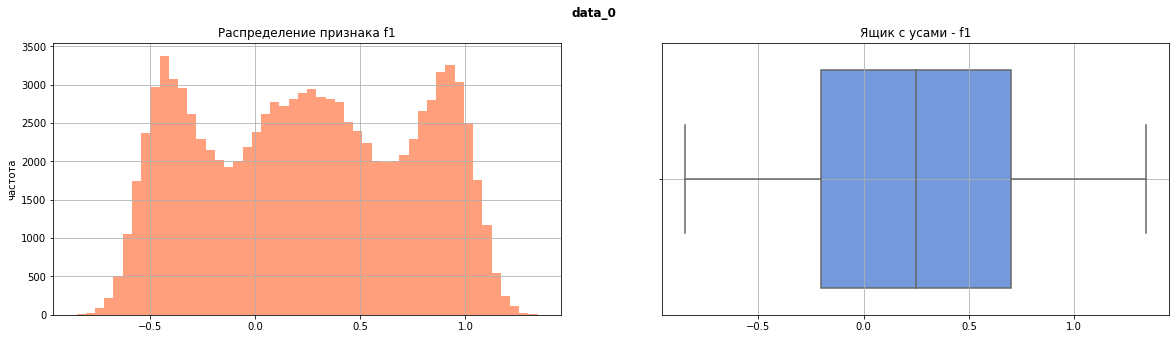

,count,mean,std,min,25%,50%,75%,max
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769


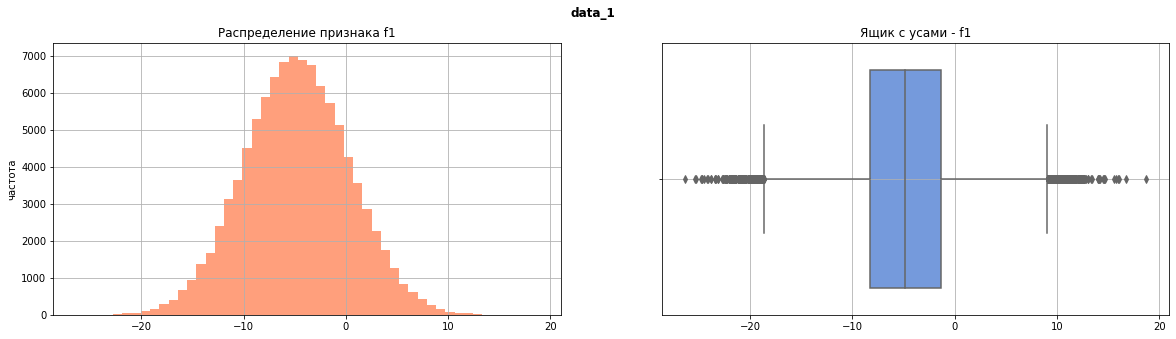

,count,mean,std,min,25%,50%,75%,max
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063


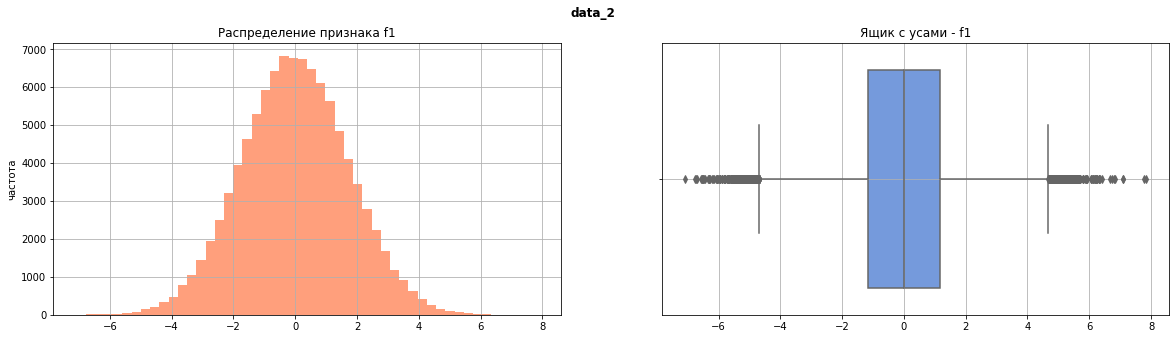

,count,mean,std,min,25%,50%,75%,max
f1,100000.0,-0.002081,1.730417,-7.08402,-1.17482,-0.009482,1.163678,7.844801


In [20]:
make_hists('f1', 50, '')

В data_0: 
* распеределие равномерное с 3 пиками, среднее 0.25, размах от -0.8	до 1.3

В data_1:
* Среднее -4.8, разброс от -26.4 до 18.7 - самый большой. Распределение близко к нормальному.

В data_2:
* Среднее 0, разброс от -7 до 7.8. Распределение близко к нормальному.

**Признак `f2`**

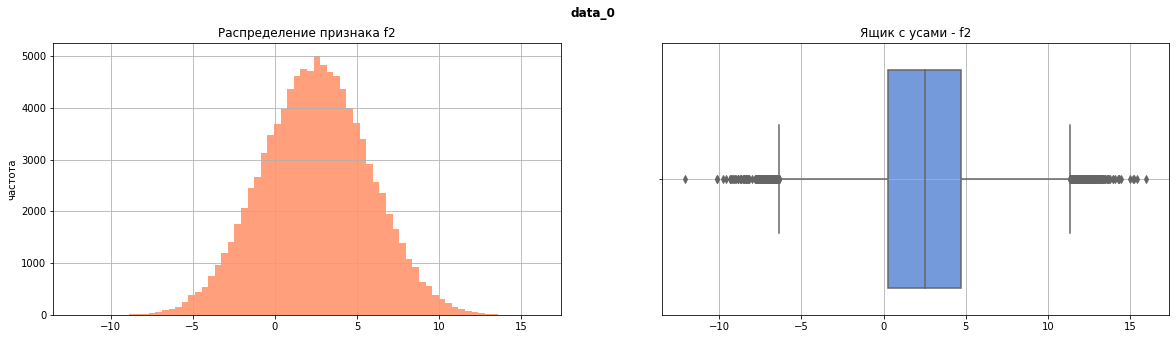

,count,mean,std,min,25%,50%,75%,max
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.00379


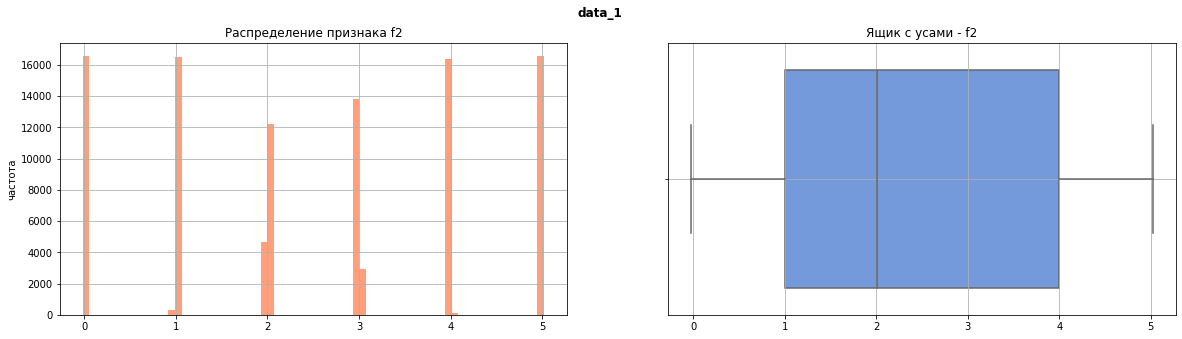

,count,mean,std,min,25%,50%,75%,max
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721


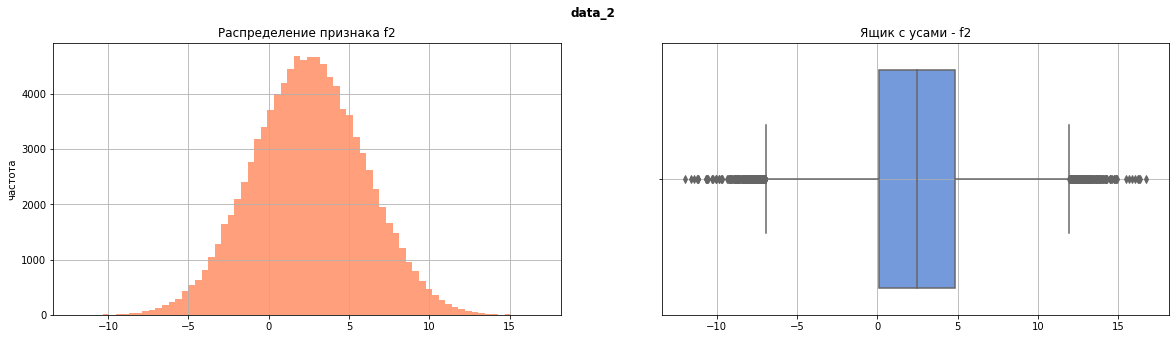

,count,mean,std,min,25%,50%,75%,max
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402


In [21]:
make_hists('f2', 70, '')

В data_0: 
* распеределие близко к нормальному. Среднее 2.502647, распределение от	-12.1 до 16

В data_1:
* Среднее 2.494541, разброс от -0.02 до 4. 
* Распределение равномерное. Значения встречаются примерно в равных количествах на всем промежутке от минимума до максимума.

В data_2:
* Среднее 2.5, разброс от -11.97 до 16.74. Распределение близко к нормальному.

**Выведем на экран средние значения точек f0-f1-f2 для датасетов:**

In [22]:
print ('Средние значения трех точек:')
p=0
for df in list_data:
    print (f'data_{p}:', df['f0'].mean().round(2), df['f1'].mean().round(2), df['f2'].mean().round(2))
    p+=1

Средние значения трех точек:
data_0: 0.5 0.25 2.5
data_1: 1.14 -4.8 2.49
data_2: 0.0 -0.0 2.5


* Признаками f0-f1-f2 датасеты описываются примерно таким образом.

Заметим, что в среднем признак f1 для разных датасетов практически не различается.

#### Вывод:

`product`:

Самые высокие объемы запаса в data_0 и data_2:
* Среднее 92.5/95
* Разброс
  * от 56.5 до 185.4
  * от 59.5 до 190
  
В data_1 меньше уникальных значений (12 - при том, что в значениях f0,f1,f2 имеем много уникальных значений). Видимо, это связано с тем, что данные синтетические.
* Среднее 68.8
* Разброс от 27 до 138

`f0`, `f1`, `f2`:
Средние значения трех точек:
* data_0: (0.5,  0.25, 2.5)
* data_1: (1.14, -4.8, 2.49)
* data_2: (0.0,  -0.0, 2.5)

В среднем признак f1 для разных датасетов практически не различается.

Распределения признаков либо близки к нормальному, либо равномерны с несколькими пиками.

### Корреляционный анализ

Построим матрицы корреляций:

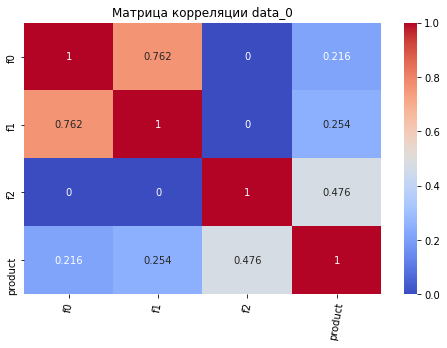

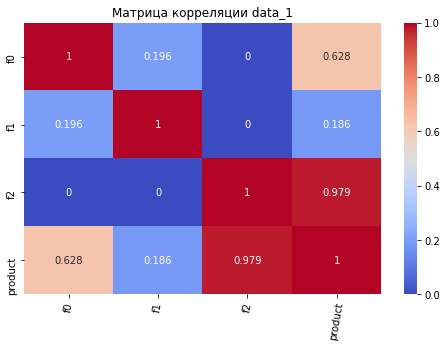

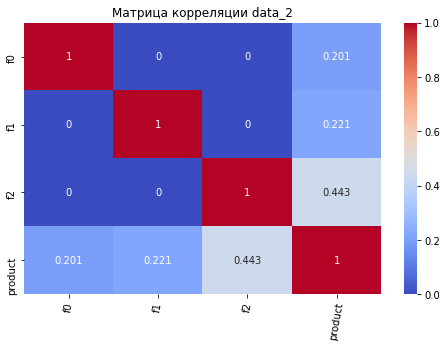

In [23]:
interval_cols = ['f0', 'f1', 'f2', 'product']
p=0
for df in list_data:
    figsize = (4,4)
    fig, ax = plt.subplots(figsize=(8,5))
    plt.title(f'Матрица корреляции data_{p}')
    sns.heatmap(df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols), 
                ax=ax, annot=True, fmt='.3g', cmap='coolwarm')
    plt.xticks(rotation=80)
    plt.show()
    p+=1

* Мультиколлинеарности между входными признаками не наблюдаем.

Корреляции входных признаков с целевым довольно слабые для data_0 и data_2:
* 0.2, 0.22 и 0.44 для f0, f1 и f2 соответственно

Есть довольно сильная корреляция 0.762 между f0 и f1 в data_0. В остальном связи между входными признаками отсутствуют (либо малы)

Очень сильная корреляция целевого признака с входным заметна в data_1:
* 0.979  
(Данные синтетические - есть сомнения в том, что такая корреляция будет и на реальных данных)

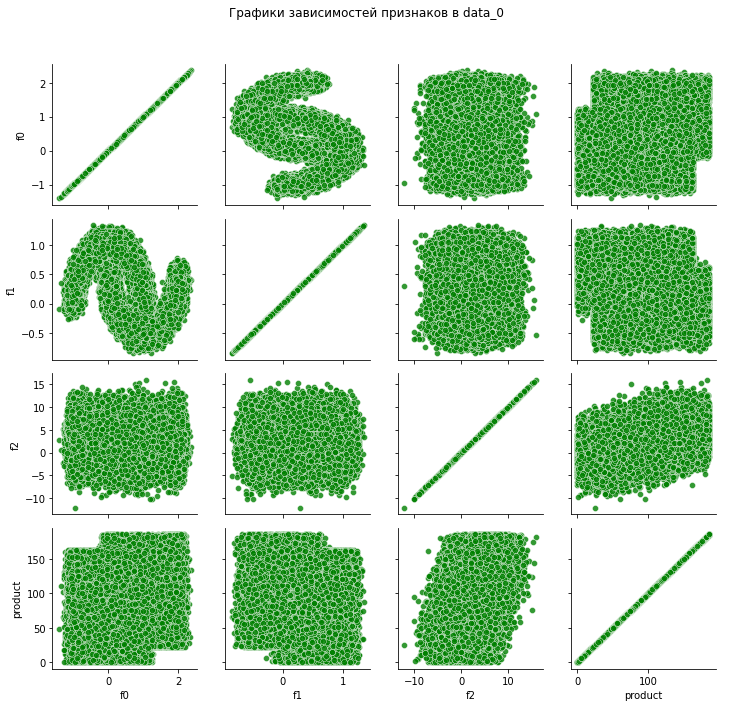

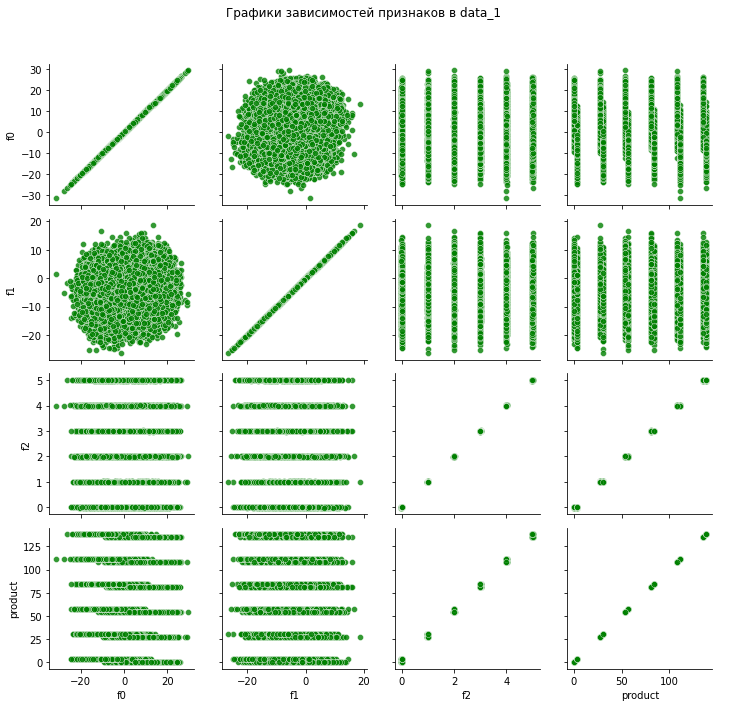

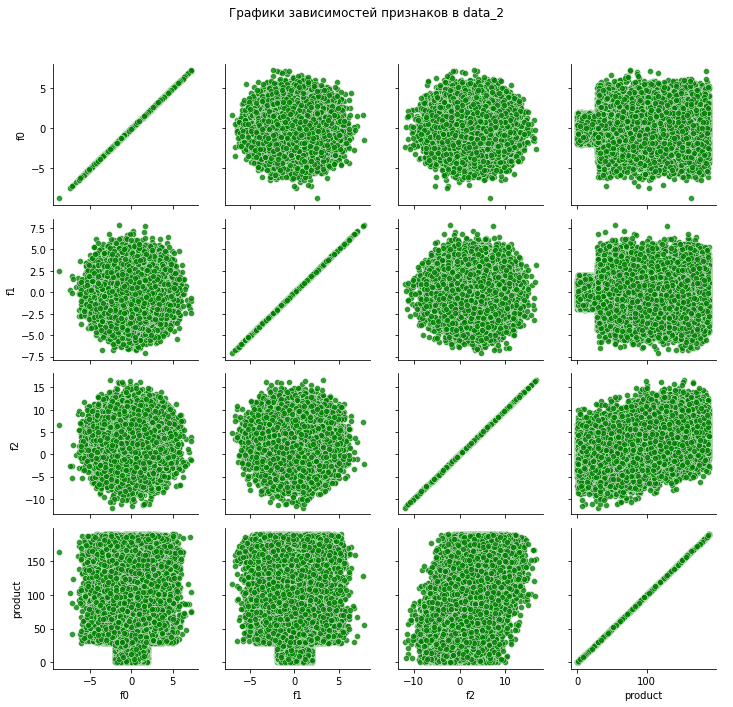

In [24]:
p = 0
for df in list_data:
    g = sns.PairGrid(df)
    g.map(sns.scatterplot, alpha=0.8, color='green')
    g.add_legend()
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Графики зависимостей признаков в data_{p}')
    p+=1
    plt.show()

**Вывод:**

Характеры связи (при наличии) с целевым признаком:

data_0:
* слабая линейная - f2 (0.48)
* слабая, ближе к категориальной - f0,f1 (0.22, 0.25)

data_1:
* сильная линейная - f2 (0.98)

data_2:
* слабая линейная - f2 (0.44)
* слабая, ближе к категориальной - f0,f1 (0.2, 0.22)

Очевидна сильная линейная корреляция между признаками `f2` и `product` в data_1.

Значения `product` ниже 20 встречаются только в случаях, когда
* В data_0:
  * f0 < 1.7 / f1 > -0.3
* В data_1:
  * на всех промежутках значений f0,f1,f2 
* В data_2:
  *  -2.5 < f0 < 2.5 / -2.5 < f1 < 2.5

## Обучение и проверка модели


### Выборки

Разобьем датасеты на тренировочную и валидационную выборки в соотношении 75:25

Функция для разбития датасета на выборки:

In [25]:
def to_split(df):
    X = df.drop(['id', 'product'], axis=1) 
    y = df['product']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    return X_train, X_test, y_train, y_test

Применяем её к каждому из датасетов:

In [26]:
X_0_train, X_0_test, y_0_train, y_0_test = to_split(data_0)
X_1_train, X_1_test, y_1_train, y_1_test = to_split(data_1)
X_2_train, X_2_test, y_2_train, y_2_test = to_split(data_2)

Проверим корректность выполнения на data_0:

In [27]:
for i in [X_0_train, X_0_test, y_0_train, y_0_test]:
    display(i.head(1))
    print(i.shape)

,f0,f1,f2
98980,1.611925,-0.151874,1.221668


(75000, 3)


,f0,f1,f2
75721,0.599283,-0.557623,2.121187


(25000, 3)


98980    105.179287
Name: product, dtype: float64

(75000,)


75721    122.07335
Name: product, dtype: float64

(25000,)


В выборках корректные признаки и размерность.

### Обучение модели

Практически наверняка масштабирование нам не понадобится, поскольку все значения входящих переменных и так находятся на очень малом отрезке, без выбросов.

Тем не менее, убедимся в этом, обучив модели с разными скейлерами (в т.ч. и без).

Сделаем это через пайплайн.

Составление пайплайна:

In [28]:
# К масштабированию - все входящие признаки
num_columns = X_0_train.columns

# Указываем шаги подготовки (только для num, т.к. других входящих признаков у нас нет)
data_preprocessor = ColumnTransformer([('num', StandardScaler(), num_columns),], remainder='passthrough')

# Итоговый пайплайн
pipe_final = Pipeline([('preprocessor', data_preprocessor), ('models', LinearRegression())])

# Параметры, которые будем перебирать (только скейлеры / их отсутствие)
param_grid = [{'models': [LinearRegression()], 'preprocessor__num': ['passthrough', StandardScaler(), MinMaxScaler()]}]

Функция для перебора:

In [29]:
def models_to_fit(X_train, y_train):
    # Добавим вычисление MSE через make_scorer, чтобы использовать в scoring в grid_search
    ## Эта метрика нам подойдет: на данном этапе важно лишь сравнить, будут ли изменения метрики при разных скейлерах
    mse = make_scorer(mean_squared_error, greater_is_better=False)
    # Поиск по сетке
    grid_search = GridSearchCV(pipe_final, param_grid, cv=2, scoring=mse, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    # Сохраняем результаты
    lr_models = pd.DataFrame(grid_search.cv_results_)
    
    return (grid_search.best_estimator_, lr_models.sort_values(by='rank_test_score'))

Применяем функцию к тренировочным выборкам всех трех датасетов:

In [30]:
best_model_0, models_0 = models_to_fit(X_0_train, y_0_train)
best_model_1, models_1 = models_to_fit(X_1_train, y_1_train)
best_model_2, models_2 = models_to_fit(X_2_train, y_2_train)

Проверим, различаются ли значения метрики MSE (=RMSE^2) у моделей с разными скейлерами для тренировочных выборок трех датасетов:

In [31]:
names = ['train_0', 'train_1', 'train_2']
p=0
for i in [models_0, models_1, models_2]:
    print (names[p], ':')
    display(i[['param_preprocessor__num', 'mean_test_score']])
    p+=1

train_0 :


,param_preprocessor__num,mean_test_score
0,passthrough,-1419.374413
1,StandardScaler(),-1419.374413
2,MinMaxScaler(),-1419.374413


train_1 :


,param_preprocessor__num,mean_test_score
1,StandardScaler(),-0.792959
0,passthrough,-0.792959
2,MinMaxScaler(),-0.792959


train_2 :


,param_preprocessor__num,mean_test_score
0,passthrough,-1602.332785
1,StandardScaler(),-1602.332785
2,MinMaxScaler(),-1602.332785


* Метрика MSE одинаковая как без, так и со скейлером

В дальнейшем к валидационной выборке будем использовать модели, сохраненные в best_estimator_.

### Предсказания для целевой выборки

Предсказываем:

In [32]:
y_0_pred = best_model_0.predict(X_0_test)
y_1_pred = best_model_1.predict(X_1_test)
y_2_pred = best_model_2.predict(X_2_test)

### Значения метрики RMSE

In [33]:
rmse_0 = mean_squared_error(y_0_test, y_0_pred)**0.5
rmse_1 = mean_squared_error(y_1_test, y_1_pred)**0.5
rmse_2 = mean_squared_error(y_2_test, y_2_pred)**0.5

# Выводим на экран
p=0
for i in [rmse_0, rmse_1, rmse_2]:
    print (f'rmse_{p}: {i.round(2)}')
    p+=1

rmse_0: 37.76
rmse_1: 0.89
rmse_2: 40.15


Наилучшие значения показала метрика модели, обученной по data_1. Настолько низкий уровень корня среднеквадратичной ошибки, вероятно, связан с тем, что в исходных данных имели всего 12 уникальных значений целевого значения (вместо 100 тысяч).

Уровень RMSE для выборок 0 и 2 примерно на одном уровне: 37.86 и 40.15 соответственно.

**Средний запас предсказанного сырья**

In [34]:
p=0
for i in y_0_pred, y_1_pred, y_2_pred:
    print (f'Для y_{p}: {i.mean().round(2)}')
    p+=1

Для y_0: 92.4
Для y_1: 68.71
Для y_2: 94.77


Сравним с реальными средними значениеми:

In [35]:
p=0
for i in y_0_test, y_1_test, y_2_test:
    print (f'Для y_{p}: {i.mean().round(2)}')
    p+=1

Для y_0: 92.33
Для y_1: 68.73
Для y_2: 95.15


Средние значения pred оказались очень близки к реальным.

### Проверка на адекватность

Посмотрим, какие бы значения метрики rmse получили, если бы моделғ всегда предсказывала среднее значение целевых значений:

In [36]:
def dummy_check(X_train, X_test, y_train, y_test):
    dummy_lr = DummyRegressor(strategy = 'mean')
    dummy_lr.fit(X_train, y_train)
    y_pred_dummy = dummy_lr.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred_dummy)**0.5
    return rmse

In [37]:
rmse_dummy_0 = dummy_check(X_0_train, X_0_test, y_0_train, y_0_test)
rmse_dummy_1 = dummy_check(X_1_train, X_1_test, y_1_train, y_1_test)
rmse_dummy_2 = dummy_check(X_2_train, X_2_test, y_2_train, y_2_test)

# Выводим на экран значения метрик dummy
p=0
print ('dummy:')
for i in [rmse_dummy_0, rmse_dummy_1, rmse_dummy_2]:
    print (f'rmse_dummy_{p}: {i.round(2)}')
    p+=1
    
# Выводим на экран значения метрик наших моделей
p=0
print ('\nmodel:')
for i in [rmse_0, rmse_1, rmse_2]:
    print (f'rmse_model_{p}: {i.round(2)}')
    p+=1

dummy:
rmse_dummy_0: 44.28
rmse_dummy_1: 45.94
rmse_dummy_2: 44.78

model:
rmse_model_0: 37.76
rmse_model_1: 0.89
rmse_model_2: 40.15


**Вывод:**

На самом деле, работа моделей для 0 и 2 региона не сильно впечатляет, значения RMSE моделей меньше, но довольно близки к значениям метрик в условиях, когда модель присваивает всем объектам среднее значение по выборке.

Модель для региона 1 показывает действительно хороший результат RMSE.

### Анализ остатков

In [38]:
def build_joint_hist(y_test, y_pred, df_num):
    y_joint = pd.DataFrame(list(zip(y_test, y_pred)), columns=['y_pred', 'y_test'])
    make_hist(y_joint, None, 50, df_num, 'тыс. баррелей')
    display(y_joint.describe().T)
    
def residue_analysis(y_test, y_pred, df_num):
    make_hist(pd.DataFrame(y_test - y_pred), None, 50, df_num, 'остатки, тыс. баррелей')
    display(pd.DataFrame((y_test - y_pred).describe()).T)

Сравним гистограммы и ящики с усами предсказанных и реальных значений:

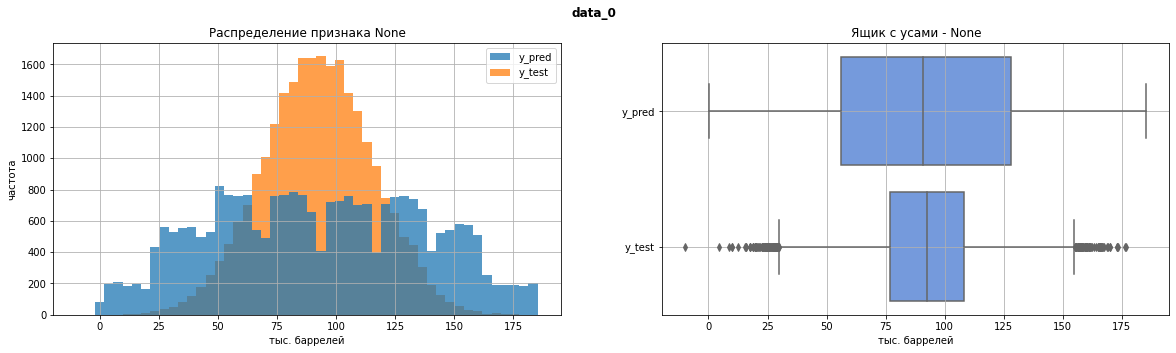

,count,mean,std,min,25%,50%,75%,max
y_pred,25000.0,92.325956,44.277512,0.021781,56.300099,90.785176,128.117571,185.355615
y_test,25000.0,92.398800,23.217563,-9.836371,76.788865,92.414871,108.036487,176.536104


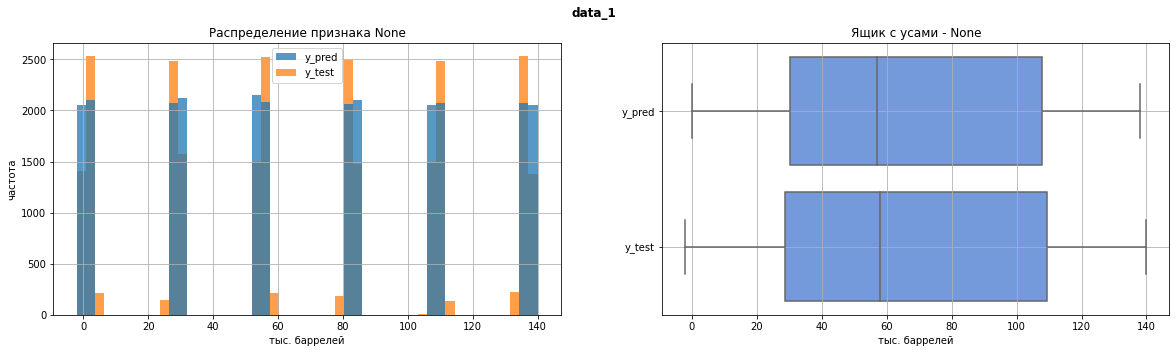

,count,mean,std,min,25%,50%,75%,max
y_pred,25000.0,68.725381,45.945586,0.000000,30.132364,57.085625,107.813044,137.945408
y_test,25000.0,68.712878,45.946672,-2.070621,28.578501,57.918041,109.313612,139.983277


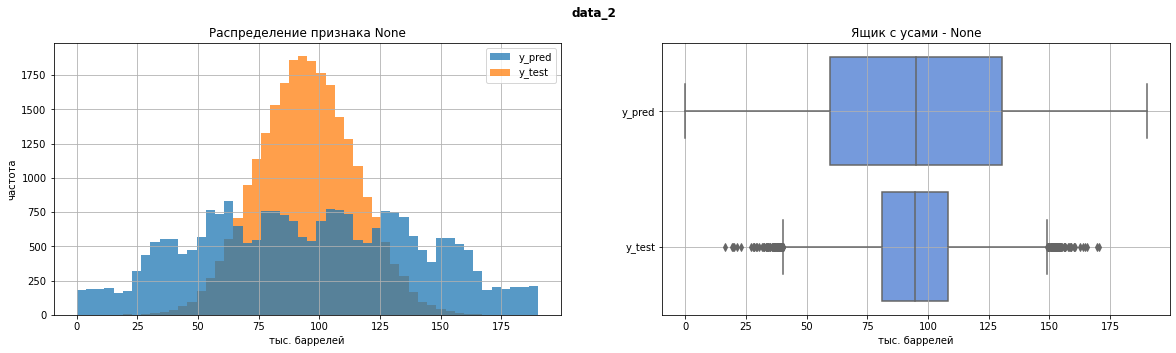

,count,mean,std,min,25%,50%,75%,max
y_pred,25000.0,95.150999,44.783220,0.019327,59.666842,94.936982,130.566313,190.011722
y_test,25000.0,94.771024,19.927375,16.196849,81.157678,94.612618,108.357649,170.529209


In [39]:
build_joint_hist(y_0_test, y_0_pred, 0)
build_joint_hist(y_1_test, y_1_pred, 1)
build_joint_hist(y_2_test, y_2_pred, 2)

В data_0 и data_2 сразу видим разницу распределений: нормального у test и равномерного у pred.

Например, в data_2 нормальными значениями, не считающимися выбросами, на test являются значения ниже 40 и больше 150. В то время как у pred таких значений нет.


**Посмотрим на распределение остатков:**

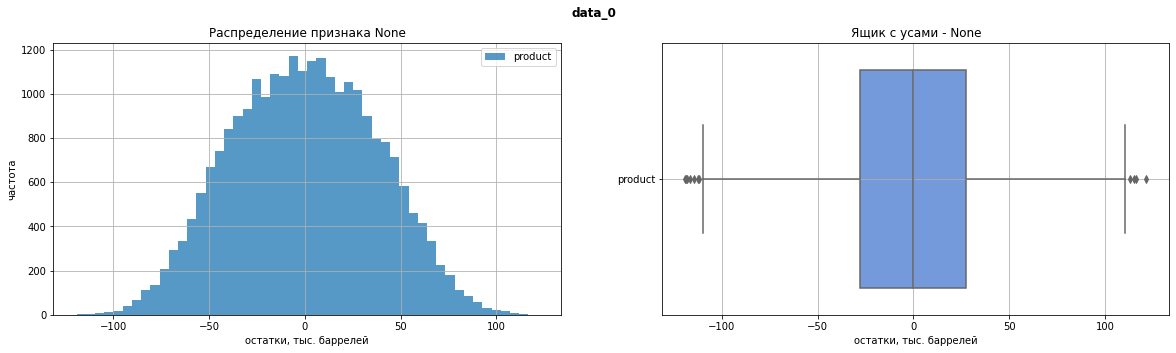

,count,mean,std,min,25%,50%,75%,max
product,25000.0,-0.072844,37.757285,-119.074439,-27.917279,-0.098192,27.594907,121.520866


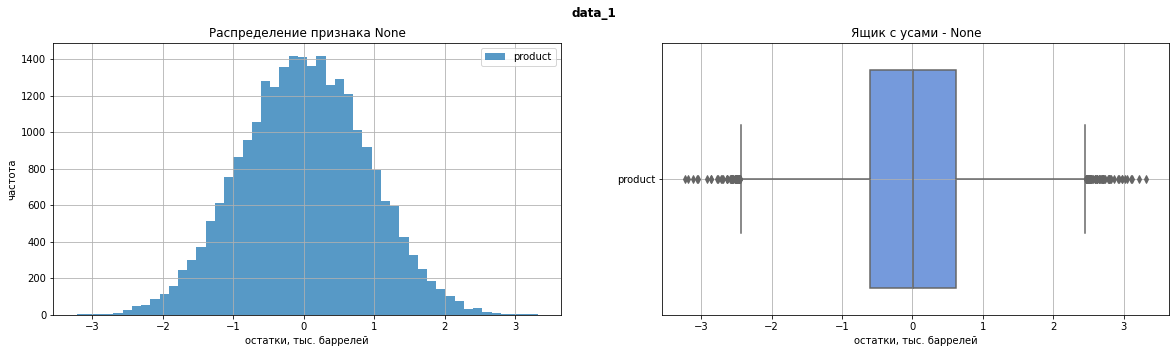

,count,mean,std,min,25%,50%,75%,max
product,25000.0,0.012503,0.89021,-3.225857,-0.600196,0.014993,0.625869,3.322995


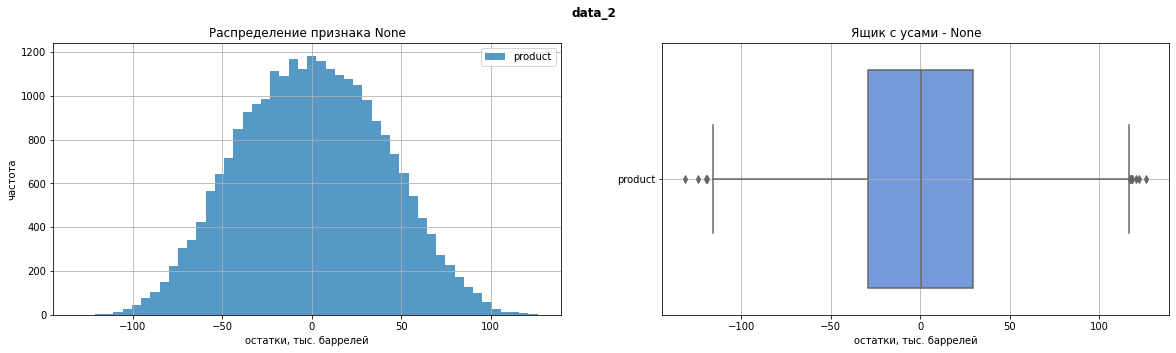

,count,mean,std,min,25%,50%,75%,max
product,25000.0,0.379975,40.144877,-131.400392,-29.053845,0.192387,29.254412,126.349866


In [40]:
residue_analysis(y_0_test, y_0_pred, 0)
residue_analysis(y_1_test, y_1_pred, 1)
residue_analysis(y_2_test, y_2_pred, 2)

Снова видим, что остатки в data_1 очень малы:
* разброс от -3.23	до 3.32 тыс. баррелей.

data_0:
* от -119.07 до	121.5

data_2:
* от -131.4 до	126.35

При этом остатки всех 3 моделей распределены нормально относительно нуля. У моделей нет перекоса в завышение или занижение результатов.

### Вывод

Обучены модели линейной регрессии для трех датасетов.

Применены к валидационным выборкам, предсказаны целевые значения, результаты метрик следующие:
* rmse_0: 37.76
* rmse_1: 0.89
* rmse_2: 40.15

Средние значения предсказанных величин (практически совпадают с реальными):
* Для y_0: 92.4
* Для y_1: 68.71
* Для y_2: 94.77

Анализ остатков показал:   
Остатки в data_1 очень малы:
* разброс от -3.23	до 3.32 тыс. баррелей.

data_0:
* от -119.07 до	121.5

data_2:
* от -131.4 до	126.35

При этом остатки всех 3 моделей распределены нормально относительно нуля. У моделей нет перекоса в завышение или занижение результатов.

В data_0 и data_2 свидим разницу распределений: нормального у test и равномерного у pred.
  * Например, в data_2 нормальными значениями, не считающимися выбросами, на test являются значения ниже 40 и больше 150. В то время как у pred таких значений нет.

## Подготовка к расчёту прибыли

Условия:  
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Сохраним ключевые значения для расчётов в отдельных переменных:

In [41]:
POINTS_NUM = 500   # количество изучаемых точек
BEST_POINTS_NUM = 200   # количество выбранных лучших точек

BUDGET = 10**10   # бюджет на разработку, руб
REVENUE_PER_BARREL = 450   # цена за баррель, руб
REVENUE_PER_PRODUCT = 450 * 1000   # цена за единицу продукта (тыс.баррелей), тыс. руб

Достаточный объём сырья для безубыточной разработки новой скважины:

In [42]:
# бюджет на разработку одной скважины
budget_for_well = BUDGET/BEST_POINTS_NUM

# достаточный объём сырья для безубыточной разработки новой скважины:
## (сколько баррелей потребуется, чтобы при цене 450 руб за баррель получить выручку в размере budget_for_well)

product_min = budget_for_well/REVENUE_PER_BARREL        #  баррелей
product_min_1000 = budget_for_well/REVENUE_PER_PRODUCT  #  тыс. баррелей

print ('Бюджет на разработку одной скважины: ', round(budget_for_well/1000000, 2), 'млн. руб')
print ('Достаточный объем для безубыточной разработки: ', round(product_min, 2), 'баррелей / ', 
       round(product_min_1000, 2), 'тыс. баррелей')


Бюджет на разработку одной скважины:  50.0 млн. руб
Достаточный объем для безубыточной разработки:  111111.11 баррелей /  111.11 тыс. баррелей


Сравним со средними запасами в каждом регионе:

In [43]:
p=0
print('Разница, тыс баррелей: \n достаточный объём сырья - средний объём сырья в регионе')
for i in list_data:
    difference = round(i['product'].mean() - product_min_1000, 2)
    print(f'data_{p}: {difference} тыс.бар. (ниже на {round(-(difference/product_min_1000)*100, 2)}%)')
    p+=1

Разница, тыс баррелей: 
 достаточный объём сырья - средний объём сырья в регионе
data_0: -18.61 тыс.бар. (ниже на 16.75%)
data_1: -42.29 тыс.бар. (ниже на 38.06%)
data_2: -16.11 тыс.бар. (ниже на 14.5%)


* Средний объем сырья в каждом регионе меньше минимального, необходимого для безубыточной работы:
  * В лучшем случае на 14.5%, в худшем - на 38%

### Вывод

При выборе 200 лучших точек, общем бюджете на разработу в 10 млрд.руб и цене за баррель в 450 руб имеем:
* 50 млн руб - бюджет на разработку одной скважины
* 111111.11 баррелей - достаточный объём сырья для безубыточной разработки новой скважины

Разница, тыс баррелей:  
 *достаточный объём сырья - средний объём сырья в регионе*
* data_0: -18.61 тыс.бар. (ниже на 16.75%)
* data_1: -42.29 тыс.бар. (ниже на 38.06%)
* data_2: -16.11 тыс.бар. (ниже на 14.5%)

## Расчёт прибыли и рисков 

Для начала приведем y_pred и y_test к общему виду: 
* Series со стандартными индексами от 0:

In [44]:
def processing_datas(y_test, y_pred):
    y_pred = pd.Series(y_pred)
    y_test = y_test.reset_index(drop=True)
    return y_test, y_pred

In [45]:
y_test_0, y_pred_0 = processing_datas (y_0_test, y_0_pred)
y_test_1, y_pred_1 = processing_datas (y_1_test, y_1_pred)
y_test_2, y_pred_2 = processing_datas (y_2_test, y_2_pred)

Напишем функцию для рассчета выручки:

In [46]:
def profit_calculation(y_test, y_pred, best_points_num):
    # скважины с максимальными значениями предсказаний
    best_indexes_pred = y_pred.sort_values(ascending=False).head(200).index
    best_200_real_values = y_test.loc[y_test.index.isin(best_indexes_pred)]
    # выручка
    revenue = best_200_real_values.sum() * REVENUE_PER_PRODUCT
    # прибыль
    profit = revenue - BUDGET
    
    return profit

Посмотрим, какая была бы прибыль, если бы исследовали все 100000 точек и предсказали для них значения `product`:

In [47]:
profit_0_max = profit_calculation(y_test_0, y_pred_0, BEST_POINTS_NUM)
profit_1_max = profit_calculation(y_test_1, y_pred_1, BEST_POINTS_NUM)
profit_2_max = profit_calculation(y_test_2, y_pred_2, BEST_POINTS_NUM)

p=0
for i in [profit_0_max, profit_1_max, profit_2_max]:
    print (f'Прибыль региона {p}: {round(i/(10**9), 3)} млрд.руб')
    p+=1

Прибыль региона 0: 3.359 млрд.руб
Прибыль региона 1: 2.415 млрд.руб
Прибыль региона 2: 2.599 млрд.руб


**Применение Bootstrap**

Теперь посмотрим, какие результаты получим при исследовании 500 точек, создав 1000 подвыборок:

Напишем функцию:

In [48]:
def bootstrap (y_test, y_pred):
    state = np.random.RandomState(12345)
    profits = []
    for i in range(1000):
        # формируем выборки из 500 точек
        target_subsample = y_test.sample(n=POINTS_NUM, replace=True, random_state=state)
        probs_subsample = y_pred[target_subsample.index]
        # считаем для них прибыль
        profits.append(profit_calculation(target_subsample, probs_subsample, BEST_POINTS_NUM))
    profits = pd.Series(profits)
    # средняя выручка по региону
    mean_profit = profits.mean()
    # 2,5% и 97,5% квантили
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    # вероятность убытков
    risk = (profits<0).mean()
    
    return mean_profit, lower, upper, risk, profits

Посчитаем для трех регионов среднюю выручку, 95% доверительный интервал, риск убытков:

In [49]:
mean_profit_0, lower_0, upper_0, risk_0, profits_0 = bootstrap(y_test_0, y_pred_0)
mean_profit_1, lower_1, upper_1, risk_1, profits_1 = bootstrap(y_test_1, y_pred_1)
mean_profit_2, lower_2, upper_2, risk_2, profits_2 = bootstrap(y_test_2, y_pred_2)

**Средняя прибыль:**

In [50]:
p=0
for i in [mean_profit_0, mean_profit_1, mean_profit_2]:
    print (f'Регион {p}: {round(i/(10**6), 3)} млн. руб')
    p+=1

Регион 0: 406.925 млн. руб
Регион 1: 433.149 млн. руб
Регион 2: 377.558 млн. руб


* самая большая средняя прибыль - регион 1

**95% доверительный интервал средней прибыли:**

In [51]:
p=0
for i in [[lower_0, upper_0], [lower_1, upper_1], [lower_2, upper_2]]:
    print (f'Регион {p}: [', round(i[0]/(10**6), 3), ' - ', round(i[1]/(10**6), 3), '] млн. руб')
    p+=1

Регион 0: [ -117.742  -  911.737 ] млн. руб
Регион 1: [ 16.846  -  815.973 ] млн. руб
Регион 2: [ -170.78  -  901.772 ] млн. руб


* в 95% доверительном интервале 1 региона отсутствуют отрицательные значения средней прибыли

**Риск убытков:**

In [52]:
p=0
for i in [risk_0, risk_1, risk_2]:
    print (f'Регион {p}: {round(i*100, 2)}%')
    p+=1

Регион 0: 6.7%
Регион 1: 1.9%
Регион 2: 7.4%


* Единственный регион с риском убытков менее 2.5% - регион 1.
* Риски убытков регионов 0 и 2 значительно выше.

### Вывод

**Подходящий регион для разработки скважин - регион 1.**

Причины:  
* Ключевое условие для нас - риск убытков менее 2.5%.  
Выбранный регион - единственный, который подходит под это условие с риском уботыков всего 1.9%.  
* Отсутствуют отрицательные значения средней прибыли в 95% доверительном интервале.



## Общий вывод

**Результат:**  
Определен регион для разработки - регион 1, с риском убытков менее 2.5%.
* Средняя выручка: 433.149 млн. руб
* 95% доверительный интервал: 16.846  -  815.973 млн. руб

_____________
**Шаги работы:**

1. Предобработка данных: 

  * Пропусков, дубликатов (явных и неявных) обнаружено не было.  
  * Есть повторяющиеся id. Однако, нет таких строк, где кроме id совпадали бы другие признаки.  
  

2. Исследовательский анализ данных:

* `product`:
  * Самые высокие объемы запаса в data_0 и data_2:
    * Среднее 92.5/95
    * Разброс
      * от 56.5 до 185.4
      * от 59.5 до 190
  * В data_1 меньше уникальных значений (12 - при том, что в значениях f0,f1,f2 имеем много уникальных значений):
    * Среднее 68.8
    * Разброс от 27 до 138

* `f0`, `f1`, `f2`:
  * Средние значения трех точек:
    * data_0: (0.5,  0.25, 2.5)
    * data_1: (1.14, -4.8, 2.49)
    * data_2: (0.0,  -0.0, 2.5)
  * В среднем признак f1 для разных датасетов практически не различается.
  * Распределения признаков либо близки к нормальному, либо равномерны с несколькими пиками.
  
  
3. Корреляционный анализ:
  * Характеры связи (при наличии) с целевым признаком:
    * data_0:
        * слабая линейная - f2 (0.48)
        * слабая, ближе к категориальной - f0,f1 (0.22, 0.25)
    * data_1:
        * сильная линейная - f2 (0.98)
    * data_2:
        * слабая линейная - f2 (0.44)
        * слабая, ближе к категориальной - f0,f1 (0.2, 0.22)
        
        
4. Обучение и проверка модели
    * Обучены модели линейной регрессии для трех датасетов.

    * Применены к валидационным выборкам, предсказаны целевые значения, результаты метрик следующие:
        * rmse_0: 37.76
        * rmse_1: 0.89
        * rmse_2: 40.15

    * Средние значения предсказанных величин (практически совпадают с реальными):
        * Для y_0: 92.4
        * Для y_1: 68.71
        * Для y_2: 94.77

    * Анализ остатков:   
        * Остатки в data_1 очень малы:
            * разброс от -3.23	до 3.32 тыс. баррелей.

        * data_0:
            * от -119.07 до	121.5

        * data_2:
            * от -131.4 до	126.35

     * При этом остатки всех 3 моделей распределены нормально относительно нуля. У моделей нет перекоса в завышение или занижение результатов.

      * В data_0 и data_2 свидим разницу распределений: нормального у test и равномерного у pred.
          * Например, в data_2 нормальными значениями, не считающимися выбросами, на test являются значения ниже 40 и больше 150. В то время как у pred таких значений нет.
          
          
5. Подготовка к расчету прибыли:
  * При выборе 200 лучших точек, общем бюджете на разработу в 10 млрд.руб и цене за баррель в 450 руб имеем:

        * 50 млн руб - бюджет на разработку одной скважины
        * 111111.11 баррелей - достаточный объём сырья для безубыточной разработки новой скважины  
   * Разница, тыс баррелей:
        * достаточный объём сырья - средний объём сырья в регионе
            * data_0: -18.61 тыс.бар. (ниже на 16.75%)
            * data_1: -42.29 тыс.бар. (ниже на 38.06%)
            * data_2: -16.11 тыс.бар. (ниже на 14.5%)
            
6. Расчет прибыли и рисков
  * **Подходящий регион для разработки скважин - регион 1.**

Причины:

* Ключевое условие для нас - риск убытков менее 2.5%.  
Выбранный регион - единственный, который подходит под это условие с риском уботыков всего 1.9%.
* Отсутствуют отрицательные значения средней прибыли в 95% доверительном интервале.